#प्रूनिंग के लिए मानक अभ्यास

In [31]:
import copy
import math
import random
import time

import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F

# नकारात्मक संकेतों का समर्थन करने वाले फ़ॉन्ट का उपयोग करने के लिए matplotlib सेट करें
plt.rcParams['font.family'] = 'DejaVu Sans'

In [32]:
# LeNet नेटवर्क को परिभाषित करें
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=16 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=num_classes)

    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))

        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device=device)

In [33]:
# मॉडल का राज्य शब्दकोश लोड करें
checkpoint = torch.load('../ch02/model.pt')
#मॉडल में राज्य शब्दकोश लोड करें
model.load_state_dict(checkpoint)
origin_model = copy.deepcopy(model)

In [34]:
# वजन वितरण चार्ट बनाएं
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(2,3, figsize=(10, 6))

# अनावश्यक सबग्राफ हटाएं
    fig.delaxes(axes[1][2])
    
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True, 
                        color = 'green', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True, 
                        color = 'green', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

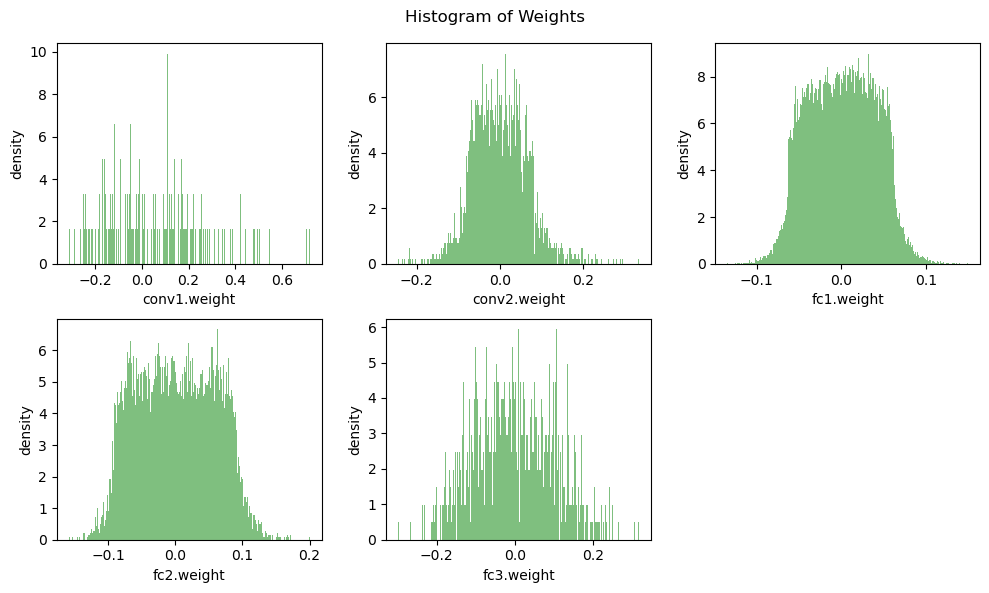

In [35]:
plot_weight_distribution(model)

In [36]:

# नेटवर्क की प्रत्येक परत के घनत्व की गणना करें
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    num_nonzeros, num_elements = 0, 0
    for name,param in model.named_parameters():
        if param.dim() > 1:
            num_nonzeros = param.count_nonzero()
            num_elements = param.numel()
            dense = float(num_nonzeros) / num_elements
            num_parameters[name] = dense
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    
    bars = plt.bar(list(num_parameters.keys()), list(num_parameters.values()))

# हिस्टोग्राम में डेटा लेबल जोड़ें
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, yval, va='bottom')  # va='bottom' 使得文本在柱状图上方

    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

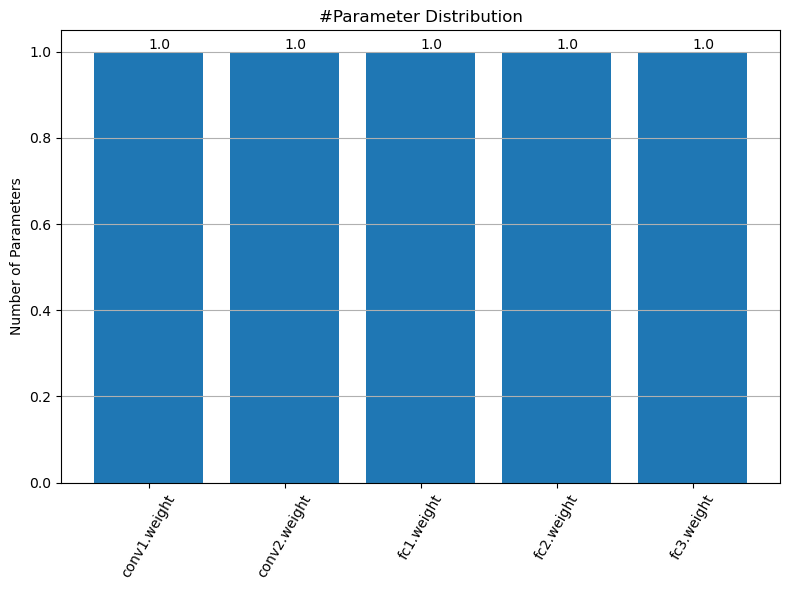

In [37]:
# वज़न हिस्टोग्राम सूचीबद्ध करें
plot_num_parameters_distribution(model)

## एल1 वजन आकार के आधार पर छंटाई

In [38]:
@torch.no_grad()
def prune_l1(weight, percentile=0.5):
    num_elements = weight.numel()

# उन मानों की संख्या की गणना करें जो 0 हैं
    num_zeros = round(num_elements * percentile)
# वजन के महत्व की गणना करें
    importance = weight.abs()
# क्लिपिंग सीमा की गणना करें
    threshold = importance.view(-1).kthvalue(num_zeros).values
# मास्क की गणना करें
    mask = torch.gt(importance, threshold)
    
# मास्क के बाद वजन की गणना करें
    weight.mul_(mask)
    return weight

In [39]:
# फसल conv2 परत
weight_pruned = prune_l1(model.conv2.weight, percentile=0.5)

In [40]:
#मूल मॉडल परत को बदलें
model.conv2.weight.data = weight_pruned

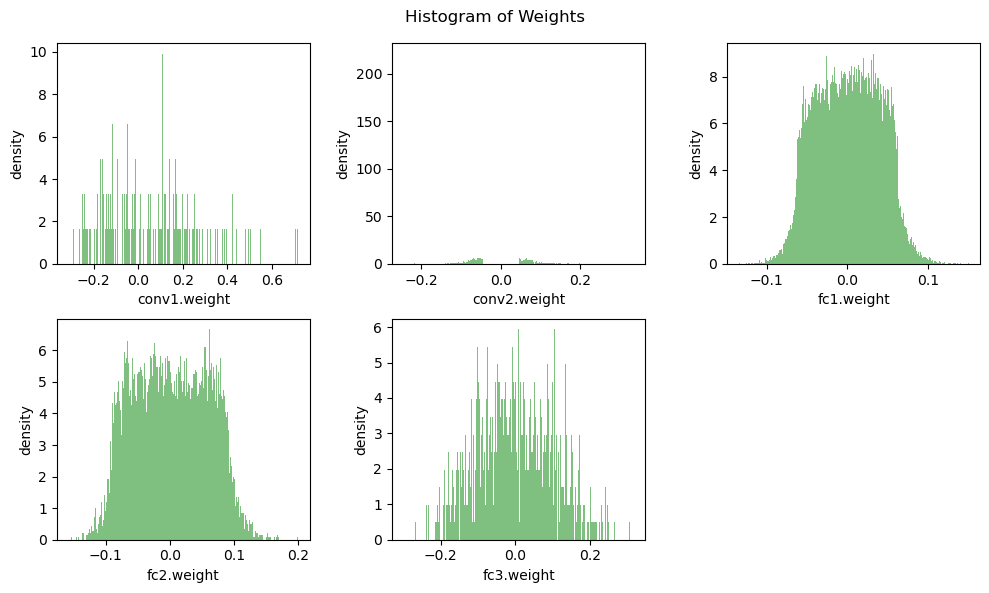

In [41]:
# वज़न हिस्टोग्राम सूचीबद्ध करें
plot_weight_distribution(model)

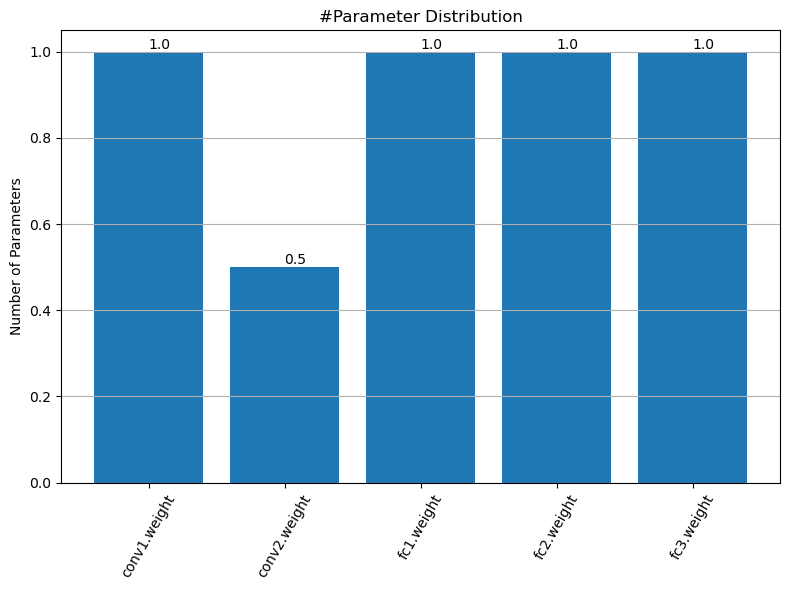

In [42]:
plot_num_parameters_distribution(model)

## L2 वजन आकार के आधार पर छंटाई

In [43]:
@torch.no_grad()
def prune_l2(weight, percentile=0.5):
    num_elements = weight.numel()

# उन मानों की संख्या की गणना करें जो 0 हैं
    num_zeros = round(num_elements * percentile)
# वजन के महत्व की गणना करें (L2 मानदंड का उपयोग करके, जो प्रत्येक तत्व का वर्ग है)
    importance = weight.pow(2)
# क्लिपिंग सीमा की गणना करें
    threshold = importance.view(-1).kthvalue(num_zeros).values
# मास्क की गणना करें
    mask = torch.gt(importance, threshold)
    
# मास्क के बाद वजन की गणना करें
    weight.mul_(mask)
    return weight


In [44]:
# fc1 परत को काटें
weight_pruned = prune_l2(model.fc1.weight, percentile=0.4)

In [45]:
#मूल मॉडल परत को बदलें
model.fc1.weight.data = weight_pruned

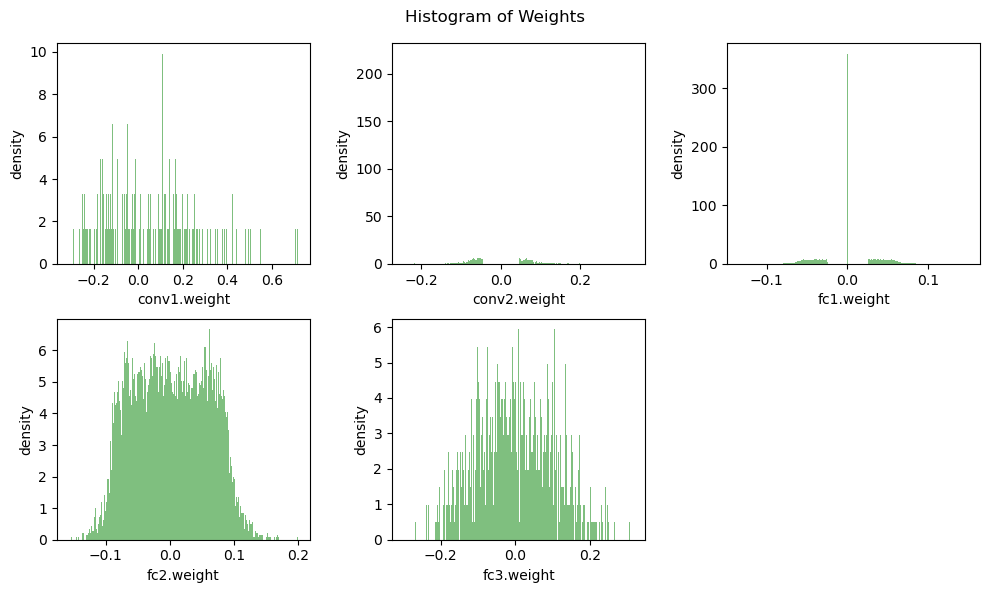

In [46]:
# वज़न हिस्टोग्राम सूचीबद्ध करें
plot_weight_distribution(model)

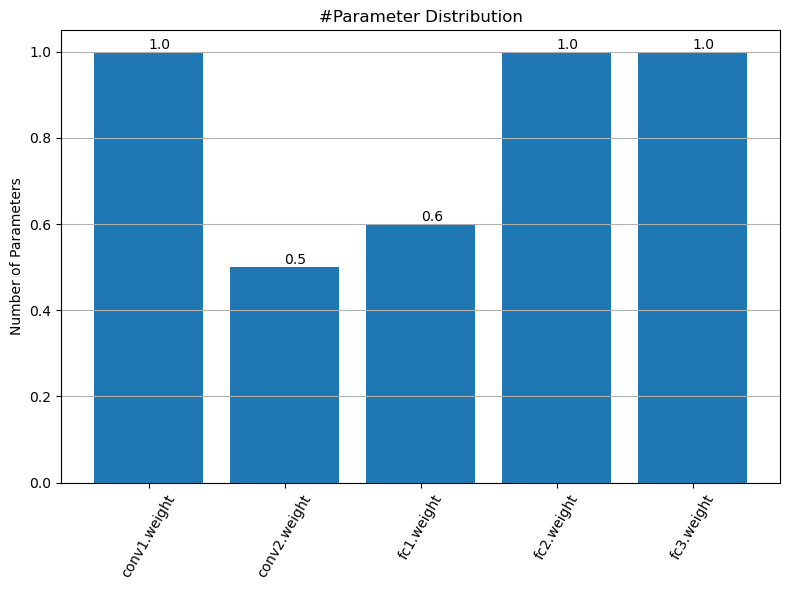

In [47]:
# वज़न हिस्टोग्राम सूचीबद्ध करें
plot_num_parameters_distribution(model)

In [48]:
#फसले वजन को बचाएं
torch.save(model.state_dict(), './model_pruned.pt')

## ढाल के आकार के आधार पर काट-छाँट

In [49]:
# LeNet नेटवर्क को परिभाषित करें
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=16 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=num_classes)

    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))

        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device=device)

In [50]:
#ग्रेडिएंट जानकारी लोड करें
gradients = torch.load('../ch02/model_gradients.pt')

In [51]:
#पैरामीटर जानकारी लोड करें
checkpoint = torch.load('../ch02/model.pt')
#मॉडल में राज्य शब्दकोश लोड करें
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [52]:
# ग्रेडिएंट आयाम के आधार पर प्रूनिंग मानदंड
def gradient_magnitude_pruning(model, percentile):
    for name, param in model.named_parameters():
        if 'weight' in name:
            mask = torch.abs(gradients[name]) >= percentile
            param.data *= mask.float()

In [53]:
@torch.no_grad()
def gradient_magnitude_pruning(weight, gradient, percentile=0.5):
    num_elements = weight.numel()

# उन मानों की संख्या की गणना करें जो 0 हैं
    num_zeros = round(num_elements * percentile)
# वजन के महत्व की गणना करें (L1 मानदंड का उपयोग करके)
    importance = gradient.abs()
# क्लिपिंग सीमा की गणना करें
    threshold = importance.view(-1).kthvalue(num_zeros).values
# मास्क की गणना करें
    mask = torch.gt(importance, threshold)
    
# मास्क के बाद वजन की गणना करें
    weight.mul_(mask)
    return weight

In [54]:
# उपयोग उदाहरण
percentile = 0.5
gradient_magnitude_pruning(model.fc2.weight, gradients['fc2.weight'], percentile)

Parameter containing:
tensor([[ 0.0000, -0.0000,  0.0000,  ..., -0.0000, -0.0000,  0.0000],
        [ 0.0759, -0.0195,  0.0000,  ...,  0.0288, -0.0328, -0.0000],
        [ 0.0000, -0.0396, -0.0000,  ..., -0.0576, -0.0101,  0.0000],
        ...,
        [-0.0331, -0.0734,  0.0000,  ...,  0.1133, -0.0629, -0.0000],
        [-0.0000, -0.0000,  0.0000,  ..., -0.0000, -0.0000,  0.0000],
        [-0.0000,  0.0444,  0.0000,  ..., -0.0475,  0.0651, -0.0000]],
       requires_grad=True)

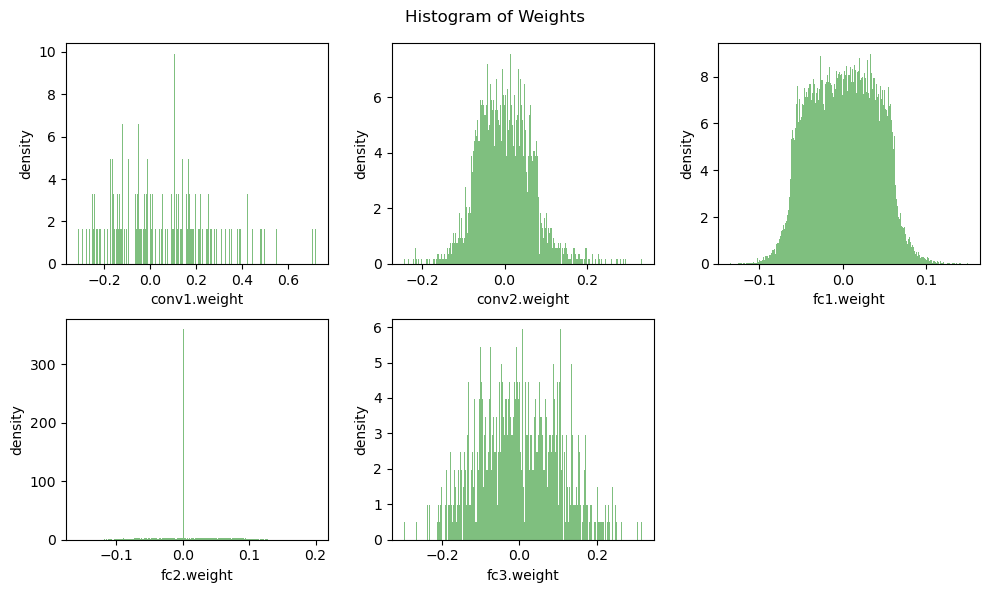

In [55]:
# वज़न हिस्टोग्राम सूचीबद्ध करें
plot_weight_distribution(model)

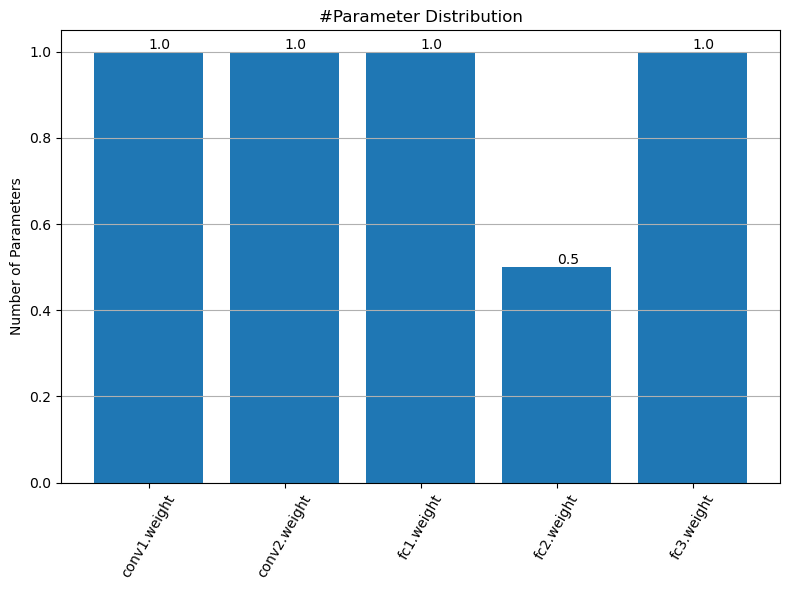

In [56]:
plot_num_parameters_distribution(model)